# Transformers model

## Setup

In [1]:
!pip install ..

Processing /home/jupyter/code/szaboildi/uk-pol-speech-classifier
  Preparing metadata (setup.py) ... done
  Created wheel for polclassifier: filename=polclassifier-0.0.1-py3-none-any.whl size=11196 sha256=6280b2173caeb2c3f058b6566a5e959d6db20cbd507c1f91933ec0e13c942c15
  Stored in directory: /home/jupyter/.cache/pip/wheels/62/8c/bc/f3bb23466cf275ad76727c3996b011e2321ab07a4eee1b8593
Successfully built polclassifier
  Attempting uninstall: polclassifier
    Found existing installation: polclassifier 0.0.1
    Uninstalling polclassifier-0.0.1:
      Successfully uninstalled polclassifier-0.0.1


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Masking, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer
from transformers import TFAutoModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from polclassifier.params import *

import gensim.downloader as api
from nltk.corpus import stopwords

2024-05-14 12:10:21.439316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 12:10:22.221055: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 12:10:25.935809: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-05-1

In [3]:
X = pd.read_csv("~/code/szaboildi/uk-pol-speech-classifier/processed_data/features_1000sample_400min_600cutoff_for_embed.csv")
y = pd.read_csv("~/code/szaboildi/uk-pol-speech-classifier/processed_data/target_1000sample_400min_600cutoff_for_embed.csv")

In [4]:
X.shape, y.shape

((7000, 1), (7000, 7))

In [5]:
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL, padding_side = "right")

tokenized_tensors = tokenizer(X["text"].tolist(), 
                              max_length=512, 
                              padding = "max_length", 
                              truncation = True, 
                              return_tensors="tf")

model = TFAutoModel.from_pretrained(HF_MODEL, 
                                    from_pt = True)

embeddings = model.predict(tokenized_tensors["input_ids"])

X_embed = embeddings.last_hidden_state[:,0,:]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-05-14 12:11:00.182593: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-05-14 12:11:00.183249: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-14 12:11:00.183273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (polclassifier-transformers): /proc/driver/nvidia/version does not exist
2024-05-14 12:11:00

219/219 [==============================] - 339s 2s/step


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_embed, y, stratify=y)

input_shape = (embeddings.last_hidden_state.shape[-1],) 

dense_model = Sequential([
    Dense(300, activation='relu', input_shape=input_shape),
    Dense(250, activation='relu'),
    Dropout(0.4),
    Dense(150, activation='relu'),
    Dropout(0.4),
    Dense(50, activation='relu'),
    Dense(7, activation='softmax')])

es = EarlyStopping(patience=15, restore_best_weights=True, monitor="val_accuracy", mode="max", verbose=1)

def lr_schedule(epoch):
    return 0.001 * np.exp(-epoch / 10)

my_adam = Adam(learning_rate=0.00001)

dense_model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])


history = dense_model.fit(X_train, 
                          y_train, 
                          validation_split=0.2, 
                          epochs=200,
                          batch_size=5,
                          callbacks=[es, LearningRateScheduler(lr_schedule)]
                         )

dense_model.evaluate(X_test, y_test)

Epoch 1/200
840/840 [==============================] - 3s 2ms/step - loss: 1.9041 - accuracy: 0.1990 - val_loss: 1.7343 - val_accuracy: 0.2724 - lr: 0.0010
Epoch 2/200
840/840 [==============================] - 2s 2ms/step - loss: 1.6750 - accuracy: 0.3179 - val_loss: 1.5697 - val_accuracy: 0.3610 - lr: 9.0484e-04
Epoch 3/200
840/840 [==============================] - 2s 2ms/step - loss: 1.5380 - accuracy: 0.3821 - val_loss: 1.4729 - val_accuracy: 0.4038 - lr: 8.1873e-04
Epoch 4/200
840/840 [==============================] - 2s 2ms/step - loss: 1.4544 - accuracy: 0.4200 - val_loss: 1.4290 - val_accuracy: 0.4181 - lr: 7.4082e-04
Epoch 5/200
840/840 [==============================] - 2s 2ms/step - loss: 1.4070 - accuracy: 0.4424 - val_loss: 1.3488 - val_accuracy: 0.4562 - lr: 6.7032e-04
Epoch 6/200
840/840 [==============================] - 2s 2ms/step - loss: 1.3561 - accuracy: 0.4552 - val_loss: 1.3924 - val_accuracy: 0.4533 - lr: 6.0653e-04
Epoch 7/200
840/840 [=======================

[1.4348244667053223, 0.46399998664855957]

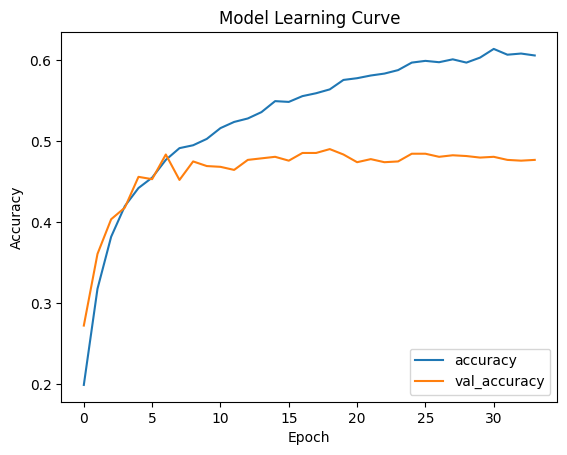

In [18]:
def plot_learning_curve(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Learning Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_learning_curve(history)

55/55 [==============================] - 0s 1ms/step


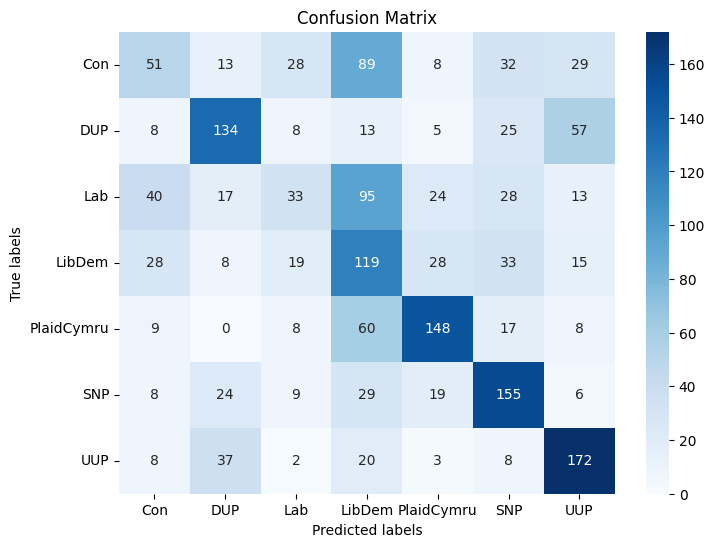

In [19]:
def plot_confusion_matrix(model):
    
    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_discrete = np.argmax(y_pred, axis=1)
    
    labels = ["Con", "DUP", "Lab", "LibDem", "PlaidCymru", "SNP", "UUP"]

    # Calculate confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_discrete)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
plot_confusion_matrix(dense_model)